In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    GlobalAveragePooling2D, Reshape, MultiHeadAttention,
    Add, Activation
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [10]:
# dataset directory
dataset_dir = "dataset-allin/sorted"

# load and preprocess the dataset
data = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),  # Resize to match ResNet50 input
    batch_size=32,
    shuffle=True
)

# split the dataset into train, validation, and test sets
def split_dataset(dataset, train_size=0.7, val_size=0.2):
    total_size = dataset.cardinality().numpy()
    train_dataset = dataset.take(int(total_size * train_size))
    val_test_dataset = dataset.skip(int(total_size * train_size))
    val_dataset = val_test_dataset.take(int(total_size * val_size))
    test_dataset = val_test_dataset.skip(int(total_size * val_size))
    return train_dataset, val_dataset, test_dataset

train, val, test = split_dataset(data)

# prefetch for performance
train = train.prefetch(tf.data.AUTOTUNE)
val = val.prefetch(tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)

Found 1839 files belonging to 3 classes.


In [11]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.1)
])
train = train.map(lambda x, y: (data_augmentation(x), y))

# load the ResNet50 model without the top layer
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, LayerNormalization, MultiHeadAttention, Add, Input, Flatten
from tensorflow.keras.models import Model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

def build_hybrid_model(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)
    # CNN Backbone
    base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    base_model.trainable = False  # Optionally fine-tune later

    x = base_model.output  # (batch, 7, 7, 2048)
    x = Reshape((49, 2048))(x)  # 7*7=49

    # Transformer Encoder Blocks
    for _ in range(2):  # You can increase the number of blocks
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# Usage
model = build_hybrid_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
# Get number of classes from your dataset
num_classes = len(data.class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {data.class_names}")


Number of classes: 3
Class names: ['0', '1', '2']


In [15]:
from tensorflow.keras.models import Sequential

# build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Global pooling layer
    Dense(512, activation='relu'),  # Dense layer for feature extraction
    Dropout(0.5),  # Dropout for regularization
    Dense(3, activation='softmax')  # 3 classes: first, second, and third-degree burns
])

# compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


In [17]:
# train the model
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8539 - loss: 0.3491 - val_accuracy: 0.7784 - val_loss: 0.5426 - learning_rate: 2.5000e-04
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8633 - loss: 0.3299 - val_accuracy: 0.8182 - val_loss: 0.4962 - learning_rate: 2.5000e-04
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8750 - loss: 0.3193 - val_accuracy: 0.7983 - val_loss: 0.5270 - learning_rate: 2.5000e-04
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8766 - loss: 0.3312 - val_accuracy: 0.8125 - val_loss: 0.5303 - learning_rate: 1.2500e-04
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8805 - loss: 0.3244 - val_accuracy: 0.7756 - val_loss: 0.5252 - learning_rate: 1.2500e-04


In [18]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np

# initialize metrics
pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 0.8561
Recall: 0.8626
Accuracy: 0.7585


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


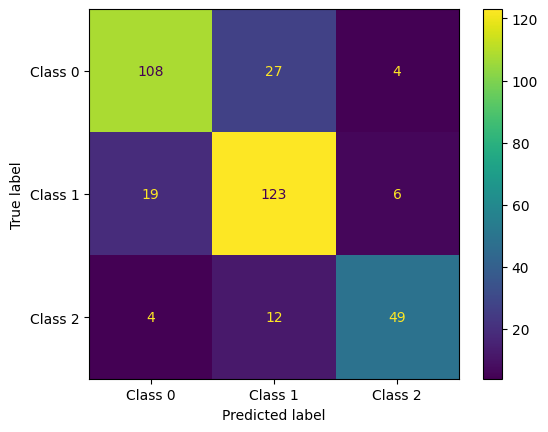

In [ ]:
#Debug Learning Progress
#Plot the confusion matrix for the validation set to identify misclassified classes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []
for images, labels in val:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1', 'Class 2'])
disp.plot()

In [ ]:
# Save the entire model (architecture + weights + optimizer)
model.save('checkpoints/FINAL NA FINAL NA FINAL NA/hybrid_resnet_transformer_vanilla.h5')

In [22]:
# 1. Get the ResNet50 backbone from your model
resnet = model.get_layer('resnet50')

# 2. Unfreeze only the last 30 layers
for layer in resnet.layers[-30:]:
    layer.trainable = True

# Re-compile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_finetune = model.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 256s 6s/step - accuracy: 0.6703 - loss: 0.7608 - val_accuracy: 0.7699 - val_loss: 0.5898 - learning_rate: 1.0000e-05
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 228s 6s/step - accuracy: 0.7680 - loss: 0.5483 - val_accuracy: 0.8125 - val_loss: 0.5676 - learning_rate: 1.0000e-05
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 226s 6s/step - accuracy: 0.8055 - loss: 0.4792 - val_accuracy: 0.7699 - val_loss: 0.5541 - learning_rate: 1.0000e-05
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 229s 6s/step - accuracy: 0.8094 - loss: 0.4789 - val_accuracy: 0.7926 - val_loss: 0.5742 - learning_rate: 5.0000e-06
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 227s 6s/step - accuracy: 0.8289 - loss: 0.4345 - val_accuracy: 0.8040 - val_loss: 0.5027 - learning_rate: 5.0000e-06


In [23]:
resnet = model.get_layer('resnet50')
for layer in resnet.layers[-60:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 272s 6s/step - accuracy: 0.7578 - loss: 0.5692 - val_accuracy: 0.7699 - val_loss: 0.5903 - learning_rate: 1.0000e-05
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 246s 6s/step - accuracy: 0.8070 - loss: 0.4712 - val_accuracy: 0.8011 - val_loss: 0.5208 - learning_rate: 1.0000e-05
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 238s 6s/step - accuracy: 0.8258 - loss: 0.4340 - val_accuracy: 0.8125 - val_loss: 0.5542 - learning_rate: 1.0000e-05
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 218s 5s/step - accuracy: 0.8430 - loss: 0.3928 - val_accuracy: 0.8125 - val_loss: 0.5274 - learning_rate: 5.0000e-06
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 222s 6s/step - accuracy: 0.8422 - loss: 0.3985 - val_accuracy: 0.8352 - val_loss: 0.4673 - learning_rate: 5.0000e-06
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 216s 5s/step - accuracy: 0.8336 - loss: 0.4008 - val_accuracy: 0.8125 - val_loss: 0.4546 - learning_rate: 5.0000e-06
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 218s 5s/step - accuracy: 0.8492 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 0.9462
Recall: 0.8849
Accuracy: 0.7971
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step


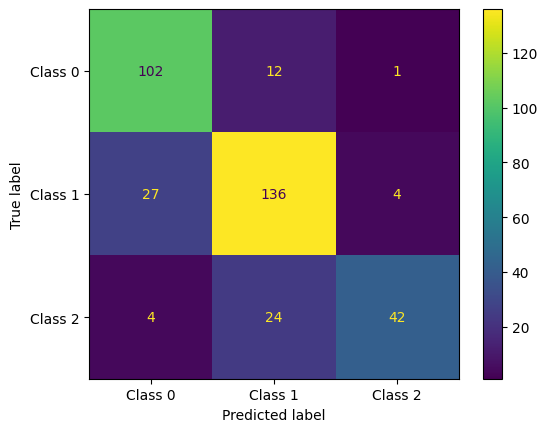

In [25]:
# evaluate the fine-tuned model
# initialize metrics
pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

#Debug Learning Progress
#Plot the confusion matrix for the validation set to identify misclassified classes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []
for images, labels in val:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1', 'Class 2'])
disp.plot()

In [ ]:
model.save('checkpoints/FINAL NA FINAL NA FINAL NA/hybrid_resnet_transformer_finetuned_60layers.keras')

In [ ]:
# unfreezing the entire backbone for fine-tuning
resnet = model.get_layer('resnet50')
for layer in resnet.layers:
    layer.trainable = True

# Re-compile with a lower learning rate
model.compile(
    optimizer = Adam(learning_rate=1e-6),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history_finetune_all = model.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
14/40 ━━━━━━━━━━━━━━━━━━━━ 2:17 5s/step - accuracy: 0.8936 - loss: 0.2812